In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
torch.manual_seed(0) 
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
#from models.WGAN import WGAN

def show_tensor_images(image_tensor, num_images=25, size=(3, 1, 16)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

In [7]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers import Concatenate

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal

from functools import partial

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt

In [8]:
class RandomWeightedAverage(Concatenate):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , grad_weight
        , z_dim
        , batch_size
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02) # 'he_normal' #RandomNormal(mean=0., stddev=0.02)
        self.grad_weight = grad_weight
        self.batch_size = batch_size


        self.d_losses = []
        self.g_losses = []
        self.epoch = 0

        self._build_critic()
        self._build_generator()

        self._build_adversarial()

    def gradient_penalty_loss(self, y_true, y_pred, interpolated_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, interpolated_samples)[0]

        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)

    def wasserstein(self, y_true, y_pred):
        return -K.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = Dropout(rate = self.critic_dropout_rate)(x)

        x = Flatten()(x)

        # x = Dense(512, kernel_initializer = self.weight_init)(x)

        # x = self.get_activation(self.critic_activation)(x)
        
        critic_output = Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = Model(critic_input, critic_output)

    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x)
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
        
        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
                
            else:
                x = Activation('tanh')(x)

        generator_output = x
        self.generator = Model(generator_input, generator_output)




    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti


    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val

    def _build_adversarial(self):
                
        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.set_trainable(self.generator, False)

        # Image input (real sample)
        real_img = Input(shape=self.input_dim)

        # Fake image
        z_disc = Input(shape=(self.z_dim,))
        fake_img = self.generator(z_disc)

        # critic determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'interpolated_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          interpolated_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(
            loss=[self.wasserstein,self.wasserstein, partial_gp_loss]
            ,optimizer=self.get_opti(self.critic_learning_rate)
            ,loss_weights=[1, 1, self.grad_weight]
            )
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.set_trainable(self.critic, False)
        self.set_trainable(self.generator, True)

        # Sampled noise for input to generator
        model_input = Input(shape=(self.z_dim,))
        # Generate images based of noise
        img = self.generator(model_input)
        # Discriminator determines validity
        model_output = self.critic(img)
        # Defines generator model
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate)
        , loss=self.wasserstein
        )

        self.set_trainable(self.critic, True)

    def train_critic(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size,1), dtype=np.float32)
        fake = -np.ones((batch_size,1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32) # Dummy gt for gradient penalty

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
    
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))

        d_loss = self.critic_model.train_on_batch([true_imgs, noise], [valid, fake, dummy])
        return d_loss

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1), dtype=np.float32)
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
    , n_critic = 5
    , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            if epoch % 100 == 0:
                critic_loops = 5
            else:
                critic_loops = n_critic

            for _ in range(critic_loops):
                d_loss = self.train_critic(x_train, batch_size, using_generator)

            g_loss = self.train_generator(batch_size)

            
            print ("%d (%d, %d) [D loss: (%.1f)(R %.1f, F %.1f, G %.1f)] [G loss: %.1f]" % (epoch, critic_loops, 1, d_loss[0], d_loss[1],d_loss[2],d_loss[3],g_loss))
            


            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)
                

            self.epoch+=1


    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.grad_weight
                    , self.z_dim
                    , self.batch_size
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        pickle.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

In [9]:
# run params
SECTION = 'gan'
RUN_ID = '0003'
DATA_NAME = 'flower'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

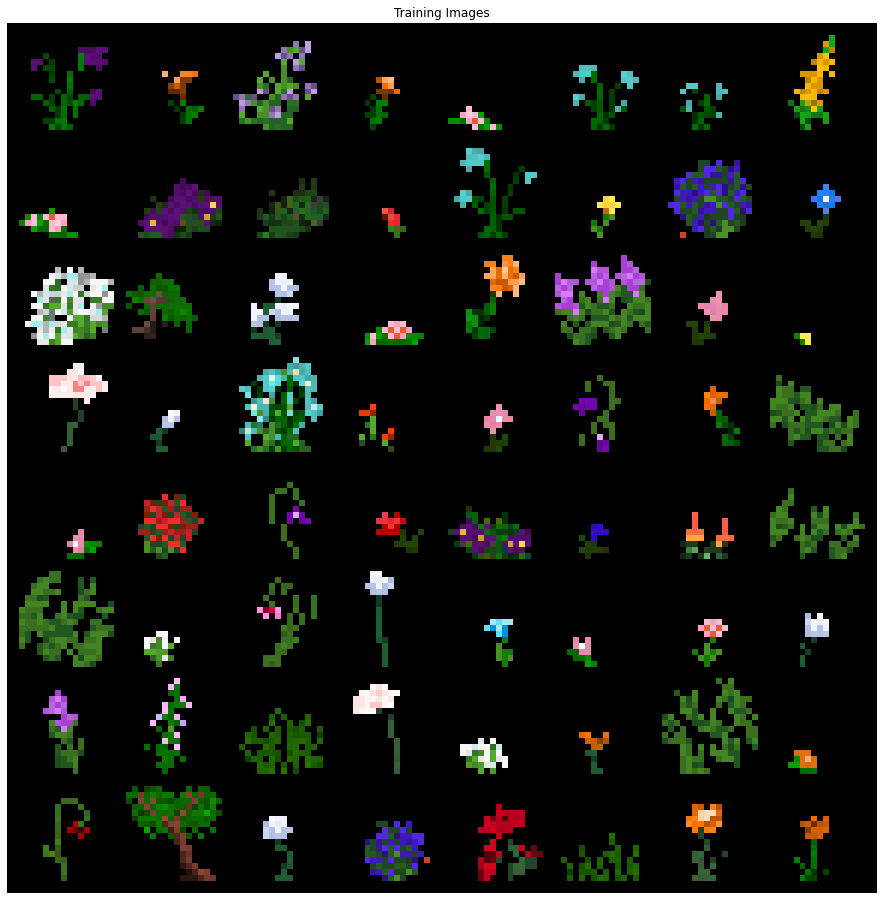

In [13]:
n_epochs = 100
z_dim = 64
display_step = 50
batch_size = 64
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
image_size = 16
workers = 2
dataroot = "../Asset/flowers"

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.RandomCrop(image_size),
                               transforms.RandomRotation(33),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [22]:
BATCH_SIZE = 64
IMAGE_SIZE = 16
x_train = dataloader
print(len(next(iter(dataloader))))
print(next(iter(dataloader))[0].shape)
print(next(iter(dataloader))[1].shape)
gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [16,32,64,128]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (4, 4, 256)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [128,64,32,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )

if mode == 'build':
    gan.save(RUN_FOLDER)

else:
    gan.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

2
torch.Size([64, 3, 16, 16])
torch.Size([64])


ValueError: Input 0 of layer dense_18 is incompatible with the layer: expected axis -1 of input shape to have value 128 but received input with shape [None, 2048]

In [ ]:
gan.critic.summary()

In [ ]:
gan.generator.summary()

In [ ]:
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5
BATCH_SIZE = 64

In [ ]:
gan.train(     
    iter(x_train)
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = True
)

In [ ]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, 2000)
# plt.ylim(0, 2)

plt.show()